In [17]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

np.random.seed(0)

# (R, LOS)
# R = expected number of reservations per day
# LOS = length of stay
n = 500 # number of simulated days
rooms = 5
january = (15 * rooms / 50, 2)
february = (20 * rooms / 50, 4)
march = (25 * rooms / 50, 4) 
april = (10 * rooms / 50, 2)
may = (5 * rooms / 50, 1.5)
june = (10 * rooms / 50, 2)
july = (15 * rooms / 50, 4)
august = (25 * rooms / 50, 4)
september = (15 * rooms / 50, 2)
october = (5 * rooms / 50, 1.5)
november = (5 * rooms / 50, 1.5)
december = (15 * rooms / 50, 2)

# Parameter of the exponential distribution
s = 15
months = {
    "january": (january, 31),
    "february": (february, 28),
    "march": (march, 31),
    "april": (april, 30),
    "may": (may, 31),
    "june": (june, 30),
    "july": (july, 31),
    "august": (august, 31),
    "september": (september, 30),
    "october": (october, 31),
    "november": (november, 30),
    "december": (december, 31),
}


In [18]:
# The expected n. of daily requests depends on the day of the week
# multiplier of n. of requests for each day of the week
days_of_week_req_rates = np.array([2 / 3, 0.5, 0.5, 4 / 3, 1.5, 2, 1.5])
# Create a vector of 730 multipliers (2 years)
days_of_week_req_rates = np.tile(days_of_week_req_rates, int(np.ceil(730 / 7)))[:730]

mesi = []
for month in months:
    mese = [months[month][0][0]] * months[month][1]
    mesi.extend(mese)
mesi = np.array(mesi*2)

# multiply for the average n. of daily requests in each month
request_rates = mesi * days_of_week_req_rates

In [19]:
# The expected LOS of requests depends on the day of the week
# multiplier of LOS for each day of the week
days_of_week_los_rates = np.array([1.5, 1, 1, 2, 1.5, 0.5, 2/3])
days_of_week_los_rates = np.tile(days_of_week_los_rates, int(np.ceil(730 / 7)))[:730]

mesi = []
for month in months:
    mese = [months[month][0][0]] * months[month][1]
    mesi.extend(mese)
mesi = np.array(mesi * 2)

# multiply for the average LOS in each month
los_rates = mesi * days_of_week_los_rates


In [24]:
# Create an array of 730 elements that containts the day of the week
# for each day of the 2 years

column_week = np.array(
    ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
)
column_week = np.tile(column_week, int(np.ceil(730 / 7)))[:730]

# Create an array of 730 elements that containts the month for each day
# of the 2 years
column_month = []
for month in months:
    v_month = [month] * months[month][1]
    column_month.extend(v_month)
column_month = np.array(column_month * 2)

# Create an array of 730 elements that containts the SST but it restarts
# When a new month begin
# Example: SST = 50 -> SST_month = 19 (february)
SST_month = []
for month in months:
    SST_month.extend(np.arange(months[month][1])+1)
SST_month *= 2

In [ ]:
def create_dataset(requests_lambda, los_lambda, lead_time_lambda, n):
    # returns a dataframe of simulated request. The columns of the df are:
    # 'RT', 'LOS', 'LT', 'SST', 'SST_month', 'days', month and day of
    # the week (as dummy vectors)
    # input:
    # requests_lambda: vector containg the lambda of the n. of requesta
    # for each day of the year(s)
    # los_lambda: vector containg the lambda of the LOS for each day of
    # the year(s)
    # lead_time_lambda: vector containg the mu of the lead time for each
    # day of the year(s)
    # n: number of simulated days
    # Output: dataframe with the simulated requests
    requests = np.random.poisson(lam=requests_lambda, size=n)
    n_of_requests = np.sum(requests)
    if type(requests_lambda) is not int:
        LOS = []
        for index, daily_requests in enumerate(requests):
            daily_los = np.random.poisson(lam=los_lambda[index], size=daily_requests)
            LOS.extend(daily_los)
        LOS = np.array(LOS)
    else:
        LOS = np.random.poisson(lam=los_lambda, size=n_of_requests)
    LOS[LOS == 0] = 1
    lead_time = np.random.exponential(scale=lead_time_lambda, size=n_of_requests)
    lead_time[lead_time < 0] = 0
    bookings = []
    counter = 0
    for index, daily_requests in enumerate(requests):
        for request in range(daily_requests):
            booking = {
                "RT": index - lead_time[counter],
                "LOS": int(LOS[counter]),
                "LT": int(lead_time[counter]),
                "SST": int(index),
                "SST_month": SST_month[index],
                "days": list(
                    range(
                        int(index),
                        int(index + LOS[counter]),
                    )
                ),
                "day_of_week": column_week[index],
                "month": column_month[index],
            }
            counter += 1
            bookings.append(booking)

    df = pd.DataFrame(bookings)
    df.sort_values(by="RT", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


In [ ]:
# Create a training and test dataset
train_df = create_dataset(request_rates, los_rates, s, n=730)
test_df = create_dataset(request_rates[:365], los_rates[:365], s, n=365)

train_df = pd.get_dummies(train_df, columns=["month", "day_of_week"])
test_df = pd.get_dummies(test_df, columns=["month", "day_of_week"])


In [ ]:
# New features that will be created to help the classification
# algorithms to understand better the currente state of the process
process_features = [
    "day -5",
    "day -4",
    "day -3",
    "day -2",
    "day -1",
    "feasible",
    "day +1",
    "day +2",
    "day +3",
    "day +4",
    "day +5",
    "arrived requests-3",
    "arrived requests-2",
    "arrived requests-1",
    "arrived requests0",
    "arrived requests1",
    "arrived requests2",
    "arrived requests3"
]

def oracle_policy(df):
    # Oracle policy that finds the best combination of accepted and
    # declined requests.
    # Input: the dataframe that we want to find the the best combination
    # of accepted and declined requests.
    # Output: 
    # the same dataframe with new columns: accepted that is 1 if
    # the request is accepted, 0 otherwise and process_features.
    # the total number of occupied rooms

    # Sets and inputs
    I = range(len(df))  # number of requests
    LOS = df.LOS.tolist()  # length of stay of request i
    RT = df.RT.tolist()  # reservation time of request i
    LT = df.LT.tolist()  # lead time of request i
    SST = [int(RT[i] + LT[i]) for i in I]  # service start time of request i
    J = range(rooms)  # rooms
    T = range(max(SST) + max(LOS))  # days

    model = gp.Model("apartment_demand")

    # Variables
    x = model.addVars(I, vtype=GRB.BINARY, name="x")
    # 1 if request i is served, 0 otherwise
    y = model.addVars(I, J, vtype=GRB.BINARY, name="y")
    # 1 if request i is assigned in room j, 0 otherwise
    z = model.addVars(I, J, T, vtype=GRB.BINARY, name="z")
    # 1 if request i is assigned in room j in day t, 0 otherwise

    # Each request can be assigned to only one room
    for i in I:
        model.addConstr(gp.quicksum(y[i, j] for j in J) == x[i])

    # All days until LOS must be occupied
    for i in I:
        for j in J:
            for t in range(LOS[i]):
                model.addConstr(z[i, j, SST[i] + t] == y[i, j])

    # A room can host only one request
    for j in J:
        for t in T:
            model.addConstr(gp.quicksum(z[i, j, t] for i in I) <= 1)

    # Objective function: maximize the number of nights accepted
    model.setObjective(gp.quicksum(x[i] * LOS[i] for i in I), GRB.MAXIMIZE)

    # Solve
    model.setParam("OutputFlag", 0)
    model.optimize()

    # Save the results
    df["accepted"] = [int(x[i].X) if x[i].X >= 0.5 else 0 for i in I]
    obj = model.ObjVal

    rooms_vector = np.zeros(max(df.SST) + max(df.LOS) + 10)
    arrived_requests = np.zeros(max(df.SST) + max(df.LOS) + 10)

    for row in range(len(df)):
        df.loc[row, process_features] = create_features(
            df.loc[row, "SST"], df.loc[row, "LOS"], rooms_vector, arrived_requests
        )

        # update arrived requests
        arrived_requests[df.loc[row, "SST"]] += 1

        # update occupied rooms
        if df.loc[row, "accepted"] == 1:
            rooms_vector[
                df.loc[row, "SST"] : df.loc[row, "SST"] + df.loc[row, "LOS"]
            ] += 1

    return df, obj

def create_features(arrival, los, rooms_vector, arrived_requests): 
    # a function that is used by oracle_policy to create process_features
    # PREVIOUS DAYS
    previous_days = []
    for previous_day in range(arrival-5, arrival):
        if previous_day < 0: previous_days.append(0)
        else: previous_days.append(rooms - rooms_vector[previous_day])
    # FEASIBILITY
    if np.all(rooms_vector[
        arrival : arrival
        + los
    ] < rooms): feasible = 1
    else:
        feasible = 0
    # ARRIVED REQUESTS
    previous_arrivals = []
    for day in range(arrival - 3, arrival+4):
        if day < 0:
            previous_arrivals.append(0)
        else:
            previous_arrivals.append(arrived_requests[day])
    return (
        *previous_days,
        feasible,
        *rooms_vector[arrival + los : arrival + los + 5] * (-1) + rooms,
        *previous_arrivals,
    )


def score(df, column_name="accepted"):
    # compute the total number of room occupied
    return np.sum(
        [
            df.iloc[row][column_name] * df.iloc[row]["LOS"]
            for row in range(len(df))
        ]
    )

In [ ]:
solved_train_df, score_oracle_train = oracle_policy(train_df.copy())
solved_test_df, score_oracle_test = oracle_policy(test_df.copy())

Set parameter Username
Set parameter LicenseID to value 2688640


Academic license - for non-commercial use only - expires 2026-07-16


In [ ]:
from scipy import stats
LOS = solved_train_df[solved_train_df.accepted == 1].LOS
# Statistical test to verify whether the LOS of a real dataset comes from
# a Poission distribution
def dispersion_test(x):
    x = np.asarray(x)
    n = len(x)
    mean = x.mean()
    I = ((x - mean) ** 2).sum() / mean
    # distribuzione sotto H0 ~ chi2(n-1)
    cdf_val = stats.chi2.cdf(I, df=n - 1)
    # p-value bilaterale
    p_value = 2 * min(cdf_val, 1 - cdf_val)
    return {"n": n, "mean": mean, "I": I, "p_value": p_value}

def poisson_chisq_gof(x, min_exp=5):
    x = np.asarray(x, dtype=int)
    n = len(x)
    lam = x.mean()
    # osservate per valore
    vals, obs = np.unique(x, return_counts=True)
    # costruisci aspettate per ogni valore fino al max osservato + qualche coda
    maxk = max(vals.max(), stats.poisson.ppf(0.999, lam).astype(int))
    ks = np.arange(0, maxk + 1)
    exp_freq = stats.poisson.pmf(ks, lam) * n

    # raggruppa ultime classi finché tutte esp >= min_exp
    obs_full = np.zeros_like(ks, dtype=int)
    for v, c in zip(vals, obs):
        obs_full[v] = c

    # raggruppamento dalla coda destra
    obs2 = obs_full.copy()
    exp2 = exp_freq.copy()
    while True:
        small = np.where(exp2 < min_exp)[0]
        if small.size == 0 or small[0] == 0:
            break
        i = small[-1]  # prendi l'ultimo indice con exp<min_exp
        # uniscilo con l'indice precedente
        exp2[i - 1] += exp2[i]
        obs2[i - 1] += obs2[i]
        exp2 = np.delete(exp2, i)
        obs2 = np.delete(obs2, i)

    chi2_stat = ((obs2 - exp2) ** 2 / exp2).sum()
    df = len(obs2) - 1 - 1 
    p_value = 1 - stats.chi2.cdf(chi2_stat, df=df)
    return {
        "n": n,
        "lambda": lam,
        "chi2": chi2_stat,
        "df": df,
        "p_value": p_value,
        "obs_bins": obs2,
        "exp_bins": exp2,
    }
print(dispersion_test(LOS))
print(poisson_chisq_gof(LOS))

{'n': 856, 'mean': np.float64(2.1296728971962615), 'I': np.float64(1080.2627537026879), 'p_value': np.float64(4.485584763624928e-07)}
{'n': 856, 'lambda': np.float64(2.1296728971962615), 'chi2': np.float64(496.03137139939724), 'df': 6, 'p_value': np.float64(0.0), 'obs_bins': array([  0, 445, 166, 108,  59,  30,  19,  29]), 'exp_bins': array([101.75800342, 216.71126196, 230.76205056, 163.81589493,
        87.21856789,  37.14940403,  13.18601315,   5.3861786 ])}


In [ ]:
# Create features df X and label vector y
X_train = solved_train_df[["LT", "LOS", "SST", "SST_month"] + process_features]
y_train = solved_train_df["accepted"]

X_test = solved_test_df[["LT", "LOS", "SST", "SST_month"] + process_features]
y_test = solved_test_df["accepted"]



In [ ]:
def random_policy(row):
    # a policy that classify randomly each observation
    p = 0.5381485249237029
    x = np.random.binomial(1, p)
    return x


def greedy_policy(row):
    # a policy that classify True each observation
    return 1 if row["feasible"].iloc[0] == 1 else 0


def online_policy(
    test_df, estimator, estimator_features=["LT", "LOS", "SST", "SST_month"] + process_features
):
    # takes a df and a model and classify each observation of the df
    # input:
    # unsolved df
    # classifier or estimator or model or policy
    # estimator_features: features needed by the model
    # output:
    # solved df with the classifier
    # score, the total number of occupied rooms
    arrived_requests = np.zeros(max(test_df.SST)+100)
    rooms_vector = np.zeros(max(test_df.SST) + 100)
    
    for row in range(len(test_df)):
        test_df.loc[row, process_features] = create_features(
            test_df.loc[row, "SST"], test_df.loc[row, "LOS"], rooms_vector, arrived_requests
        )

        # UPDATE ARRIVED REQUESTS
        arrived_requests[test_df.loc[row, "SST"]] += 1

        # STIMA DELLA DECISIONE
        if test_df.loc[row, "feasible"] == 1:
            prediction = estimator(test_df.loc[[row], estimator_features])
            prediction = float(np.ravel(prediction)[0])

            if prediction < 0.5:
                test_df.loc[row, "predicted"] = 0
            else:
                test_df.loc[row, "predicted"] = 1
        else:
            test_df.loc[row, "predicted"] = 0

        # SE ACCETTATO, AGGIUNGI I GIORNI OCCUPATI
        if test_df.loc[row, "predicted"] == 1:
            rooms_vector[
                test_df.loc[row, "SST"] : test_df.loc[row, "SST"]
                + test_df.loc[row, "LOS"]
            ] += 1
        

    score = np.sum(test_df.LOS*test_df.predicted)
    return test_df, score

In [13]:
a, b = online_policy(
    test_df=test_df.copy(),
    estimator=greedy_policy
)
print(f"Performance of greedy policy: {b}/{score_oracle_test}")


Performance of greedy policy: 873.0/940.0


In [17]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score


accuracy:  0.7292576419213974


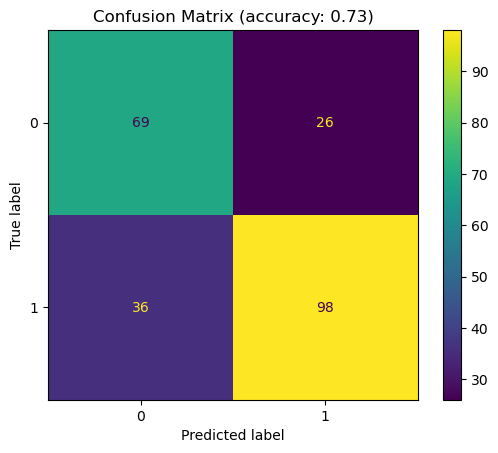

In [28]:
clf_dt = DecisionTreeClassifier(random_state=15)  
clf_dt = clf_dt.fit(X_train, y_train)

y_pred = clf_dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_dt.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_dt.classes_)
disp.plot()
plt.title(f"Confusion Matrix (accuracy: {accuracy_score(y_test, y_pred):.2f})")
print("accuracy: ", accuracy_score(y_test, y_pred))

In [29]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts = []

for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=15, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

the best alpha is  0.0019982527512647993


<function matplotlib.pyplot.show(close=None, block=None)>

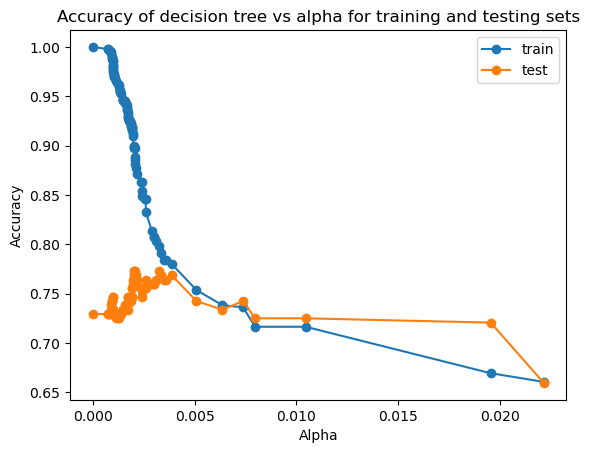

In [30]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()  # aumenta la larghezza
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy of decision tree vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train")
ax.plot(ccp_alphas, test_scores, marker="o", label="test")
#ax.set_xticks(np.arange(0.001, 0.04, 0.0015))  # mostra ~20 tick

# calcolo punteggio migliore
best_index = np.argmax(test_scores)
best_alpha = ccp_alphas[best_index]
print("the best alpha is ", best_alpha)

ax.legend()
plt.show

<Axes: xlabel='tree'>

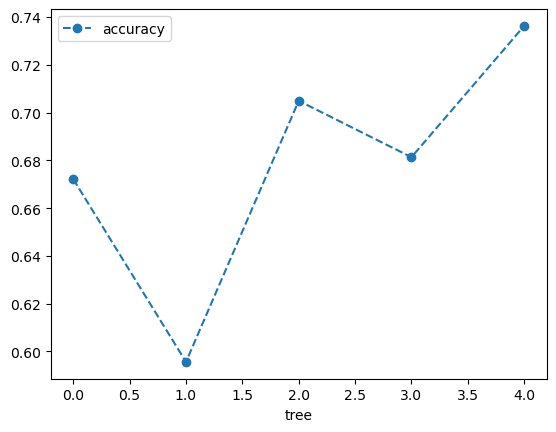

In [31]:
clf_dt = DecisionTreeClassifier(random_state=15, ccp_alpha=best_alpha)

scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df_scores = pd.DataFrame(data={"tree":range(5),"accuracy": scores})
df_scores.plot(x="tree", y = "accuracy", marker="o", linestyle = "--")

<Axes: xlabel='alpha'>

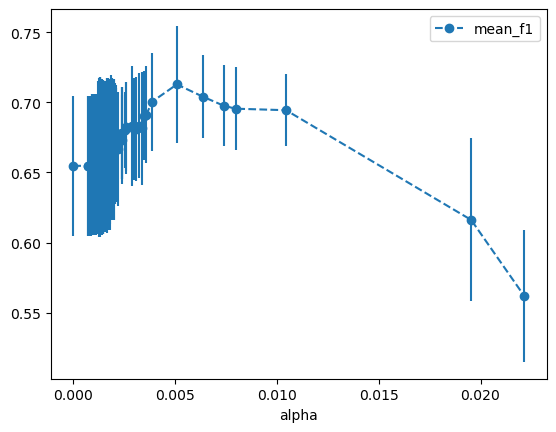

In [32]:
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=15, ccp_alpha=ccp_alpha)
    scores = cross_val_score(
        clf_dt, X_train, y_train, cv=5, scoring="f1_macro")
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values, columns=["alpha", "mean_f1", "std"])
alpha_results.plot(x="alpha", y="mean_f1", yerr="std", marker="o", linestyle="--")


In [33]:
best_index = np.argmax(alpha_results.mean_f1)
best_alpha = ccp_alphas[best_index]
best_alpha = ccp_alphas[-3]
print("best_alpha = ", best_alpha)

best_alpha =  0.010450293180487007


accuracy:  0.7248908296943232


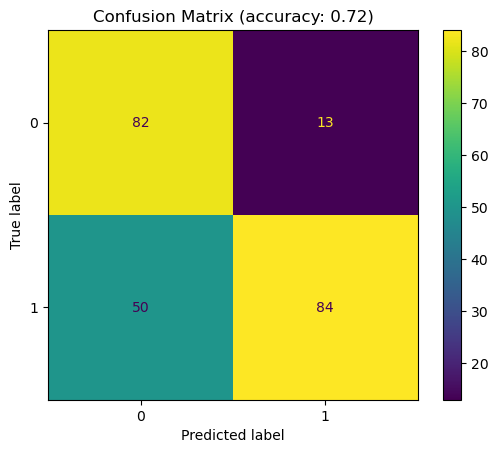

In [34]:
clf_dt_pruned = DecisionTreeClassifier(random_state=15, ccp_alpha=best_alpha)
clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

y_pred = clf_dt_pruned.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf_dt_pruned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_dt_pruned.classes_)
disp.plot()
plt.title(f"Confusion Matrix (accuracy: {accuracy_score(y_test, y_pred):.2f})")
print("accuracy: ", accuracy_score(y_test, y_pred))


In [35]:
clf_dt = clf_dt.fit(X_train, y_train)
c, d = online_policy(
    test_df=test_df.copy(),
    estimator=clf_dt_pruned.predict,
    estimator_features=X.columns
)

print(f"Performance of greedy policy: {b}/{score_oracle_test}")
print(f"Performance of clf policy: {d}/{score_oracle_test}")


Performance of greedy policy: 2109.0/2442.0
Performance of clf policy: 1030.0/2442.0


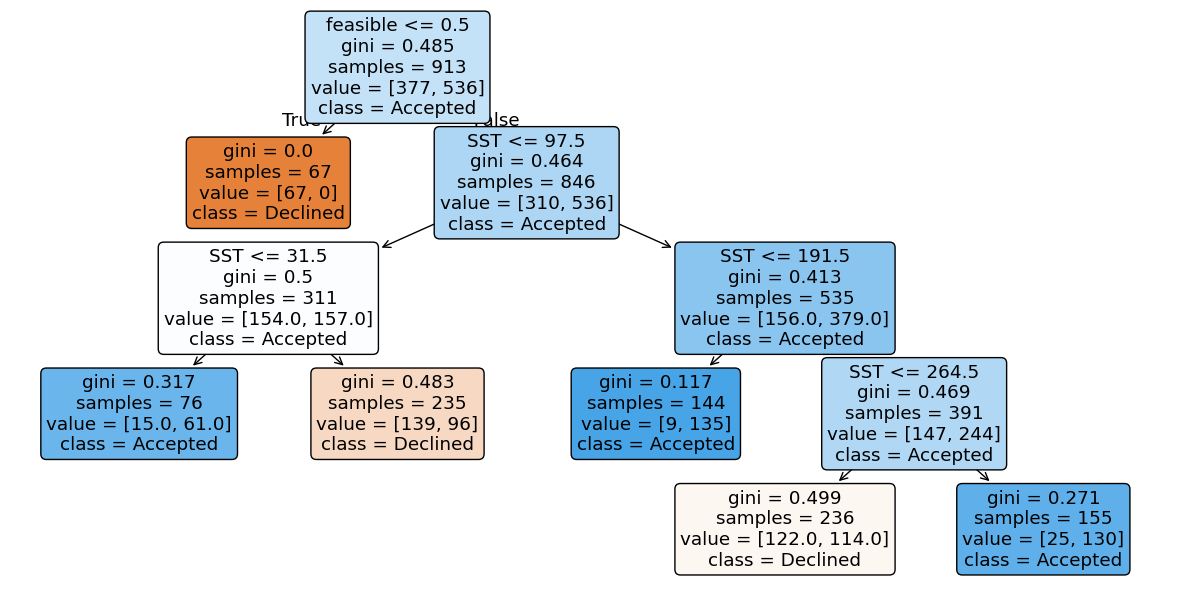

In [36]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt_pruned, filled=True, rounded=True, class_names=["Declined", "Accepted"], feature_names=X.columns)
plt.savefig("dt disegno.png")

In [37]:
import xgboost as xgb

clf_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=15,
    # early_stopping_rounds=10,
)

clf_xgb.fit(
    X_train.values,  # Convert to numpy array
    y_train.values,  # Convert to numpy array
    verbose=True,
    eval_set=[(X_test.values, y_test.values)],  # Convert eval_set too
)


[0]	validation_0-logloss:0.60025
[1]	validation_0-logloss:0.55579
[2]	validation_0-logloss:0.53044
[3]	validation_0-logloss:0.51856
[4]	validation_0-logloss:0.49713
[5]	validation_0-logloss:0.48106
[6]	validation_0-logloss:0.47814
[7]	validation_0-logloss:0.47209
[8]	validation_0-logloss:0.46811
[9]	validation_0-logloss:0.46957
[10]	validation_0-logloss:0.47147
[11]	validation_0-logloss:0.46439
[12]	validation_0-logloss:0.46873
[13]	validation_0-logloss:0.46478
[14]	validation_0-logloss:0.46052
[15]	validation_0-logloss:0.46138
[16]	validation_0-logloss:0.45674
[17]	validation_0-logloss:0.46456
[18]	validation_0-logloss:0.45999
[19]	validation_0-logloss:0.46239
[20]	validation_0-logloss:0.45806
[21]	validation_0-logloss:0.46285
[22]	validation_0-logloss:0.46475
[23]	validation_0-logloss:0.46696
[24]	validation_0-logloss:0.46435
[25]	validation_0-logloss:0.46698
[26]	validation_0-logloss:0.46994
[27]	validation_0-logloss:0.46709
[28]	validation_0-logloss:0.46464
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [38]:
xgb_solved_df, xgb_score = online_policy(
    test_df=test_df.copy(), estimator=clf_xgb.predict, estimator_features=X.columns
)

print(f"Performance of greedy policy: {b}/{score_oracle_test}")
print(f"Performance of xgb policy: {xgb_score}/{score_oracle_test}")


Performance of greedy policy: 2109.0/2442.0
Performance of xgb policy: 2127.0/2442.0


accuracy:  0.7510917030567685


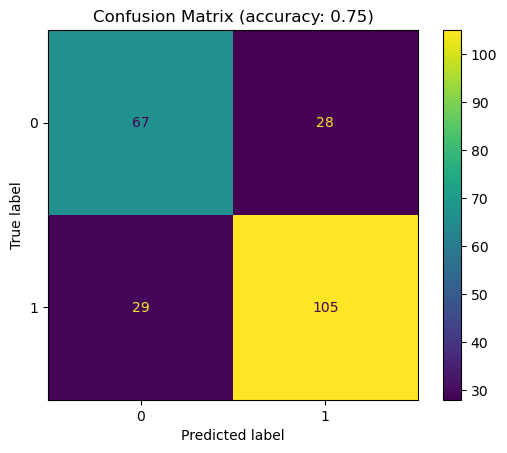

In [40]:
y_pred = clf_xgb.predict(X_test.values)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix (accuracy: {accuracy_score(y_test, y_pred):.2f})")
print("accuracy: ", accuracy_score(y_test, y_pred))

In [41]:
xgb_solved_df, xgb_score = online_policy(
    test_df=test_df.copy(), estimator=clf_xgb.predict, estimator_features=X.columns
)

print(f"Performance of greedy policy: {b}/{score_oracle_test}")
print(f"Performance of xgb policy: {xgb_score}/{score_oracle_test}")


Performance of greedy policy: 2109.0/2442.0
Performance of xgb policy: 2127.0/2442.0


In [42]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "max_depth": [1, 2, 3, 4, 5, 6],
    "learning_rate": list(np.arange(0.01, 1, 0.01)),
    "gamma": list(np.arange(0.01, 1, 0.01)),
    "reg_lambda": list(np.arange(1, 100, 1)),
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "n_estimators": [50, 100, 200, 300, 400],
    "scale_pos_weight": list(np.arange(0.2, 5, 0.2)),
}
n_iter_search = 30
random_search = RandomizedSearchCV(
    clf_xgb, param_distributions=param_grid, n_iter=n_iter_search
)
random_search.fit(X_train, y_train)


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=No...
                                                             np.float64(2.2),
                                                             np.float64(2.4000000000000004),
                                                             np.float64(2.6),
                                                             np.float64(2.8000000000000003),
                                                             np.float64(3.0),
                                                             np.float64(3.2),
                                                             np.float64(3.4000000000000004),
                                                             np.float64(3.6),
                                                             np.float64(3.8000000000000003),
                                                             np.float64(4.0),
                                                             np.float64(4.2),
                                                             np.float64(4.4),
                                                             np.float64(4.6000000000000005),
                                                             np.float64(4.800000000000001)],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]})

In [43]:
clf_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=15,
    # early_stopping_rounds=10,
    **random_search.best_params_,
)
clf_xgb.fit(
    X_train.values,  # Convert to numpy array
    y_train.values,  # Convert to numpy array
    verbose=True,
    eval_set=[(X_test.values, y_test.values)],
)

[0]	validation_0-logloss:0.69661
[1]	validation_0-logloss:0.68731
[2]	validation_0-logloss:0.67518
[3]	validation_0-logloss:0.66176
[4]	validation_0-logloss:0.65386
[5]	validation_0-logloss:0.64494
[6]	validation_0-logloss:0.63429
[7]	validation_0-logloss:0.62781
[8]	validation_0-logloss:0.61737
[9]	validation_0-logloss:0.61329
[10]	validation_0-logloss:0.60767
[11]	validation_0-logloss:0.60039
[12]	validation_0-logloss:0.59254
[13]	validation_0-logloss:0.58699
[14]	validation_0-logloss:0.58260
[15]	validation_0-logloss:0.57543
[16]	validation_0-logloss:0.57055
[17]	validation_0-logloss:0.56784
[18]	validation_0-logloss:0.56332
[19]	validation_0-logloss:0.56129
[20]	validation_0-logloss:0.55528
[21]	validation_0-logloss:0.55179
[22]	validation_0-logloss:0.54726
[23]	validation_0-logloss:0.54493
[24]	validation_0-logloss:0.54235
[25]	validation_0-logloss:0.53837
[26]	validation_0-logloss:0.53641
[27]	validation_0-logloss:0.53247
[28]	validation_0-logloss:0.53001
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=np.float64(0.91), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.15), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

accuracy:  0.7729257641921398


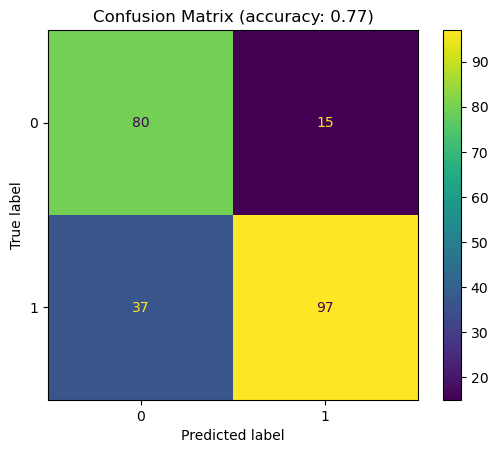

In [44]:
y_pred = clf_xgb.predict(X_test.values)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f"Confusion Matrix (accuracy: {accuracy_score(y_test, y_pred):.2f})")
print("accuracy: ", accuracy_score(y_test, y_pred))


In [45]:
xgb_solved_df, xgb_score = online_policy(
    test_df=test_df.copy(),
    estimator=clf_xgb.predict,
    estimator_features=X.columns
)

print(f"Performance of greedy policy: {b}/{score_oracle_test}")
print(f"Performance of xgb policy: {xgb_score}/{score_oracle_test}")


Performance of greedy policy: 2109.0/2442.0
Performance of xgb policy: 1727.0/2442.0


%s:  weight {'LOS': 1.0, 'SST': 7.0, 'day -1': 1.0, 'feasible': 1.0, 'arrived requests-3': 1.0, 'arrived requests0': 1.0, 'arrived requests2': 1.0}
%s:  gain {'LOS': 0.9116458892822266, 'SST': 18.7491512298584, 'day -1': 10.959535598754883, 'feasible': 80.55481719970703, 'arrived requests-3': 8.788625717163086, 'arrived requests0': 5.731163024902344, 'arrived requests2': 9.955997467041016}
%s:  cover {'LOS': 25.623809814453125, 'SST': 103.56267547607422, 'day -1': 60.31734085083008, 'feasible': 276.3807373046875, 'arrived requests-3': 59.28501510620117, 'arrived requests0': 59.039222717285156, 'arrived requests2': 42.68177032470703}
%s:  total_gain {'LOS': 0.9116458892822266, 'SST': 131.2440643310547, 'day -1': 10.959535598754883, 'feasible': 80.55481719970703, 'arrived requests-3': 8.788625717163086, 'arrived requests0': 5.731163024902344, 'arrived requests2': 9.955997467041016}
%s:  total_cover {'LOS': 25.623809814453125, 'SST': 724.938720703125, 'day -1': 60.31734085083008, 'feasibl

/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


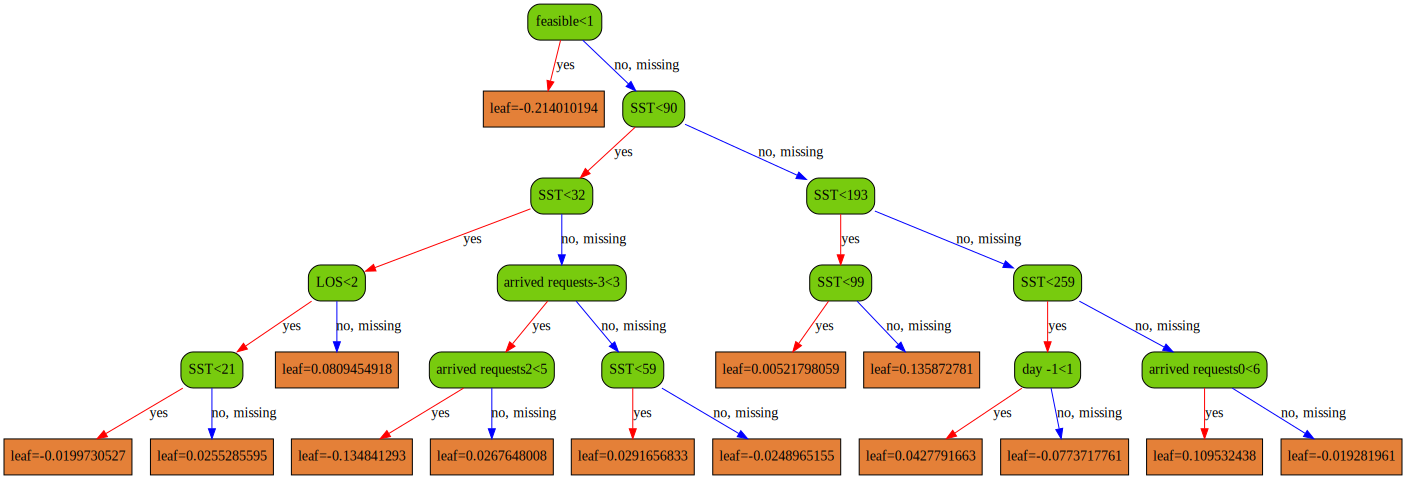

<Figure size 640x480 with 0 Axes>

In [46]:
clf_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=15,
    # early_stopping_rounds=10,
    gamma=random_search.best_params_["gamma"],
    scale_pos_weight=30/17,
    reg_lambda=random_search.best_params_["reg_lambda"],
    learning_rate=random_search.best_params_["learning_rate"],
    max_depth=5,
    n_estimators = 1
)
clf_xgb.fit(X_train, y_train)

bst = clf_xgb.get_booster()

for importance_type in ("weight","gain","cover","total_gain","total_cover"):
    print("%s: ", importance_type, bst.get_score(importance_type=importance_type))

node_params = {"shape": "box", # makes the node fancy
               "style": "filled, rounded",
               "fillcolor": "#78cbe"}
leaf_params = {
    "shape": "box",  # makes the node fancy
    "style": "filled",
    "fillcolor": "#e48038",
}
plt.savefig("tree xgb2.png")
xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)


/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


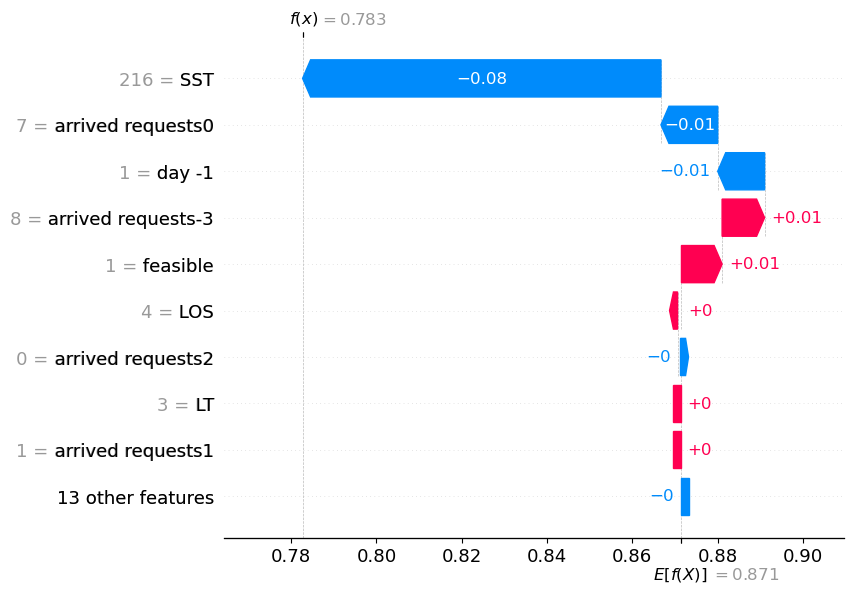

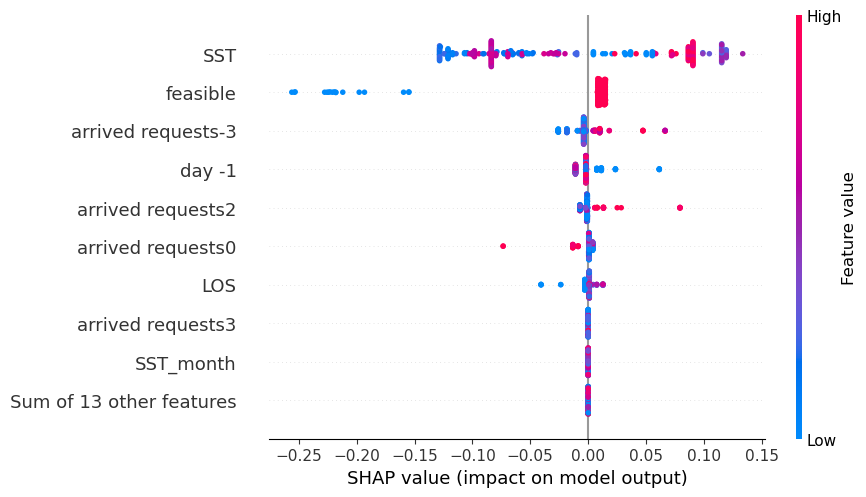

/var/folders/qg/w61l7rsj71l06c11y6x57vnw0000gn/T/ipykernel_1786/3596361649.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)


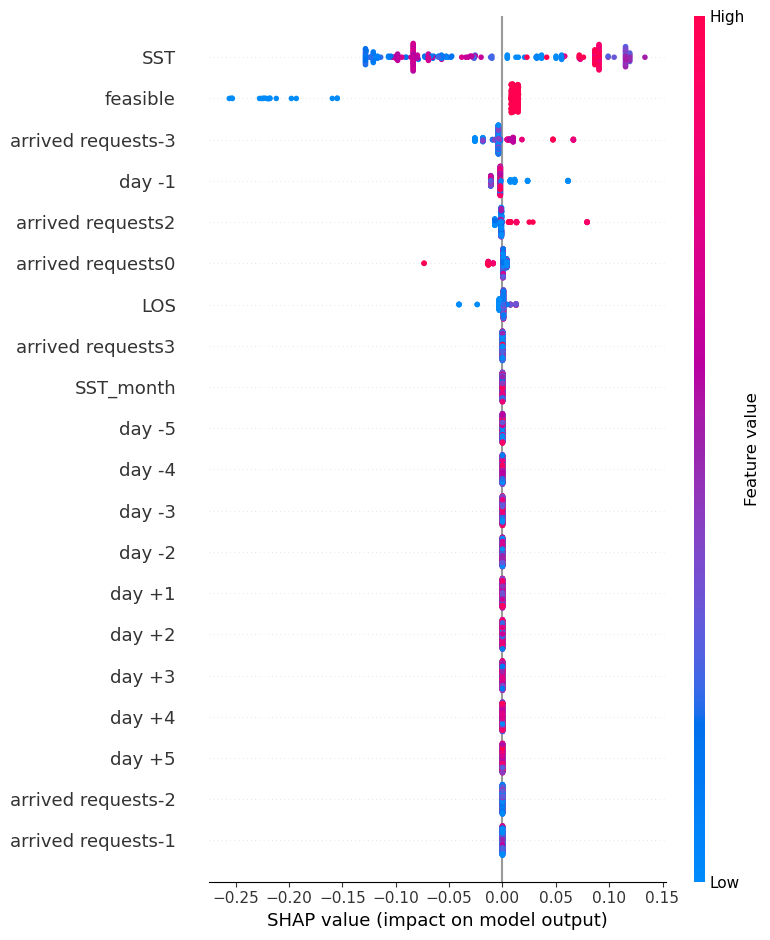

In [47]:
import shap

explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)

shap.plots.waterfall(shap_values[0])  # Per la prima predizione
shap.plots.beeswarm(shap_values)  # Panoramica globale
shap.summary_plot(shap_values.values, X_test, feature_names=X_test.columns)


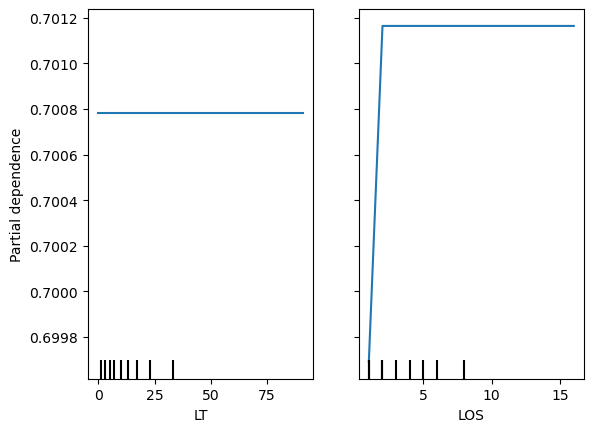

In [48]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    clf_xgb,  # il tuo modello già addestrato
    X_train,  # dati di input
    features=[0, 1],  # o i nomi delle feature, es. ['lead_time', 'los', 'day +1']
    kind="average",  # oppure "individual" o "both"
)


In [49]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier(
    n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
clf_knn.fit(X_train, y_train)
y_pred = clf_knn.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print("accuracy: ", accuracy_score(y_test, y_pred))
print("accuracy: ", clf_knn.score(X_test, y_test, sample_weight=None))

accuracy:  0.6724890829694323
accuracy:  0.6724890829694323


In [50]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "n_neighbors": np.arange(1, 100),
    "weights": ["uniform", "distance"],
    "metric": ["cosine", "minkowski"],
    "p": np.arange(1, 10),
}
n_iter_search = 100
random_search_knn = RandomizedSearchCV(
    clf_knn, param_distributions=param_grid, n_iter=n_iter_search, cv=5
)
random_search_knn.fit(X_train, y_train)
print("best parameters: ", random_search_knn.best_params_)
print("best score: ", random_search_knn.best_score_)


best parameters:  {'weights': 'distance', 'p': np.int64(3), 'n_neighbors': np.int64(52), 'metric': 'minkowski'}
best score:  0.713066714706059


accuracy:  0.6506550218340611
accuracy:  0.6506550218340611


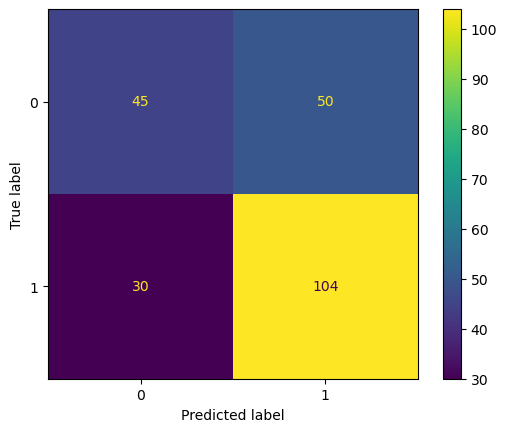

In [51]:
clf_knn = KNeighborsClassifier(
    n_neighbors=random_search_knn.best_params_["n_neighbors"],
    weights=random_search_knn.best_params_["weights"],
    algorithm="auto",
    leaf_size=30,
    p=random_search_knn.best_params_["p"],
    metric="cosine",
    metric_params=None,
    n_jobs=None,
)
clf_knn.fit(X_train, y_train)
y_pred = clf_knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print("accuracy: ", accuracy_score(y_test, y_pred))
print("accuracy: ", clf_knn.score(X_test, y_test, sample_weight=None))


In [52]:
c, d = online_policy(test_df=test_df, estimator=clf_knn.predict, estimator_features=X.columns)
print(f"Performance of clf policy: {d}/{score_oracle_test}")
print(f"Performance of greedy policy: {b}/{score_oracle_test}")


Performance of clf policy: 1860.0/2442.0
Performance of greedy policy: 2109.0/2442.0


accuracy:  0.7467248908296943


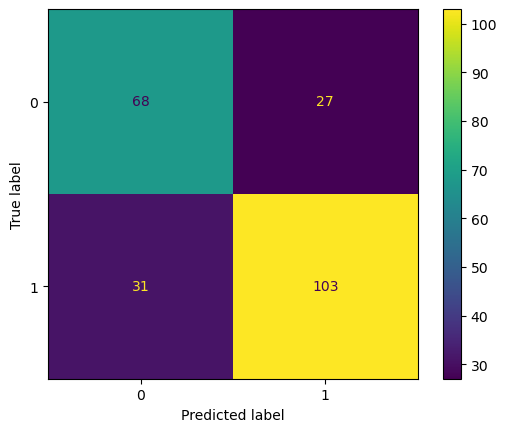

In [53]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(
    n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, verbose=0,
    min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None,
    min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=-1,random_state=None,
    warm_start=False, class_weight={0: 1, 1: 5}, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
clf_rf.fit(X_train, y_train)

# print("Out of bag error: ", clf_rf.oob_score_)

y_pred = clf_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print("accuracy: ", accuracy_score(y_test, y_pred))

In [54]:
param_grid = {
    "n_estimators": [50, 75, 90, 120, 150, 200, 250, 300, 400, 500, 600],
    "max_features": np.arange(1, X.shape[1]),
}

n_iter_search = 30
random_search_rf = RandomizedSearchCV(
    clf_rf, param_distributions=param_grid, n_iter=n_iter_search, cv=5
)
random_search_rf.fit(X_train, y_train)
print("best parameters: ", random_search_rf.best_params_)
print("best score: ", random_search_rf.best_score_)


best parameters:  {'n_estimators': 300, 'max_features': np.int64(20)}
best score:  0.7032126343601754


Out of bag error:  0.6922234392113911
accuracy:  0.7510917030567685


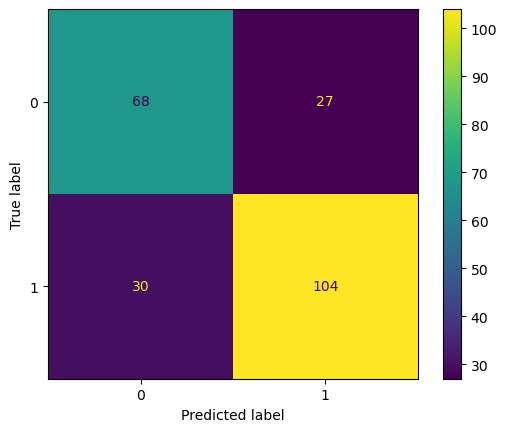

In [55]:
clf_rf = RandomForestClassifier(
    n_estimators=random_search_rf.best_params_["n_estimators"],
    max_features=random_search_rf.best_params_["max_features"],
    oob_score=True,
    n_jobs=-1,
)
clf_rf.fit(X_train, y_train)

print("Out of bag error: ", clf_rf.oob_score_)

y_pred = clf_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print("accuracy: ", accuracy_score(y_test, y_pred))


In [56]:
c, d = online_policy(test_df=test_df, estimator=clf_rf.predict, estimator_features=X.columns)
print(f"Performance of clf policy: {d}/{score_oracle_test}")
print(f"Performance of greedy policy: {b}/{score_oracle_test}")


Performance of clf policy: 2174.0/2442.0
Performance of greedy policy: 2109.0/2442.0


In [57]:
from sklearn.ensemble import GradientBoostingClassifier
clf_gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=1.0,
    max_depth=1,
    random_state=0,
    validation_fraction=0.1,
).fit(X_train, y_train)
clf_gb.score(X_test, y_test)

0.7161572052401747

In [58]:
param_grid = {
    "n_estimators": [20, 30, 50, 75, 90, 120, 150, 200, 250, 300, 400, 500],
    "max_depth": np.arange(1, 10),
    "learning_rate": np.logspace(-3, 1, 10),
}

n_iter_search = 30
random_search_gb = RandomizedSearchCV(
    clf_gb, param_distributions=param_grid, n_iter=n_iter_search, cv=5
)
random_search_gb.fit(X_train, y_train)
print("best parameters: ", random_search_gb.best_params_)
print("best score: ", random_search_gb.best_score_)


best parameters:  {'n_estimators': 120, 'max_depth': np.int64(4), 'learning_rate': np.float64(0.021544346900318832)}
best score:  0.7316459496787366


0.7161572052401747
accuracy:  0.7161572052401747


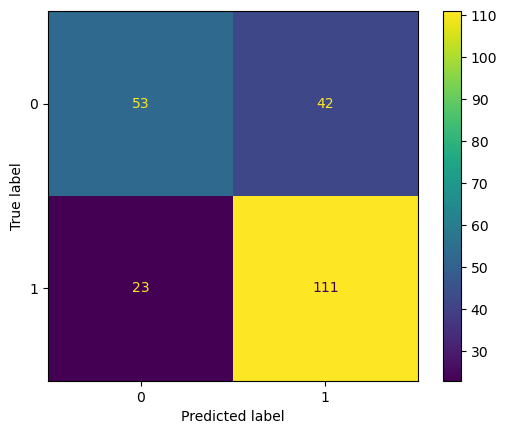

In [59]:
clf_gb = GradientBoostingClassifier(
    n_estimators=random_search_gb.best_params_["n_estimators"],
    learning_rate=random_search_gb.best_params_["learning_rate"],
    max_depth=random_search_gb.best_params_["max_depth"],
    random_state=0,
    validation_fraction=1e-10,
).fit(X_train, y_train)
print(clf_gb.score(X_test, y_test))
y_pred = clf_gb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print("accuracy: ", accuracy_score(y_test, y_pred))


In [60]:
e, f = online_policy(test_df=test_df, estimator=clf_gb.predict, estimator_features=X.columns)
print(f"Performance of clf policy: {f}/{score_oracle_test}")
print(f"Performance of greedy policy: {b}/{score_oracle_test}")


Performance of clf policy: 2099.0/2442.0
Performance of greedy policy: 2109.0/2442.0


In [61]:
greedy_solved_df, greedy_score = online_policy(test_df=test_df.copy(), estimator=greedy_policy)
print(f"Performance of greedy policy: {greedy_score}/{score_oracle_test}")

dt_solved_df, dt_score = online_policy(test_df=test_df, estimator=clf_dt.predict)
print(f"Performance of dt policy: {dt_score}/{score_oracle_test}")
xgb_solved_df, xgb_score = online_policy(test_df=test_df, estimator=clf_xgb.predict)
print(f"Performance of xgb policy: {xgb_score}/{score_oracle_test}")
# svm_solved_df, svm_score = online_policy(test_df=test_df, estimator=clf_svm.predict)
# print(f"Performance of clf policy: {svm_score}/{score_solved_test_df}")
knn_solved_df, knn_score = online_policy(test_df=test_df, estimator=clf_knn.predict)
print(f"Performance of knn policy: {knn_score}/{score_oracle_test}")
rf_solved_df, rf_score = online_policy(test_df=test_df, estimator=clf_rf.predict)
print(f"Performance of rf policy: {rf_score}/{score_oracle_test}")
gb_solved_df, gb_score = online_policy(test_df=test_df, estimator=clf_gb.predict)
print(f"Performance of gb policy: {gb_score}/{score_oracle_test}")


Performance of greedy policy: 2109.0/2442.0
Performance of dt policy: 2109.0/2442.0
Performance of xgb policy: 2109.0/2442.0
Performance of knn policy: 1860.0/2442.0
Performance of rf policy: 2174.0/2442.0
Performance of gb policy: 2099.0/2442.0


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# funzione wrapper per valutazione
def evaluate_model(
    model, model_name, param_grid, X_train, y_train, test_df, estimator_features
):
    results = []
    for params in param_grid:
        # set hyperparameters
        model.set_params(**params)
        model.fit(X_train, y_train)

        # score con online_policy
        _, score = online_policy(
            test_df=test_df,
            estimator=model.predict,
            estimator_features=estimator_features,
        )
        results.append((params, score))
        print(f"{model_name} {params} -> score {score:.3f}")
    return results


In [19]:
validation_set = create_dataset(request_rates[:365], los_rates[:365], s, n=365)
validation_set = pd.get_dummies(validation_set, columns=["month", "day_of_week"])
solved_validation_df, score_oracle_validation= oracle_policy(validation_set.copy())
score_oracle_validation


934.0

DecisionTree {'max_depth': 1, 'min_samples_split': 2} -> score 831.000 / 940.0
DecisionTree {'max_depth': 1, 'min_samples_split': 4} -> score 831.000 / 940.0
DecisionTree {'max_depth': 1, 'min_samples_split': 6} -> score 831.000 / 940.0
DecisionTree {'max_depth': 1, 'min_samples_split': 8} -> score 831.000 / 940.0
DecisionTree {'max_depth': 1, 'min_samples_split': 10} -> score 831.000 / 940.0
DecisionTree {'max_depth': 2, 'min_samples_split': 2} -> score 831.000 / 940.0
DecisionTree {'max_depth': 2, 'min_samples_split': 4} -> score 831.000 / 940.0
DecisionTree {'max_depth': 2, 'min_samples_split': 6} -> score 831.000 / 940.0
DecisionTree {'max_depth': 2, 'min_samples_split': 8} -> score 831.000 / 940.0
DecisionTree {'max_depth': 2, 'min_samples_split': 10} -> score 831.000 / 940.0
DecisionTree {'max_depth': 3, 'min_samples_split': 2} -> score 831.000 / 940.0
DecisionTree {'max_depth': 3, 'min_samples_split': 4} -> score 831.000 / 940.0
DecisionTree {'max_depth': 3, 'min_samples_split':

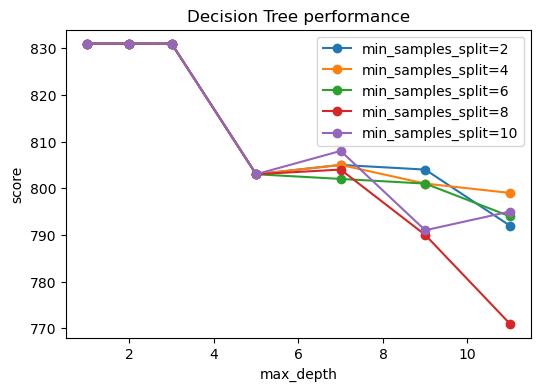

In [20]:
# hyperparameters
dt_param_grid = [
    {"max_depth": d, "min_samples_split": m} for d in [1, 2, 3, 5, 7, 9, 11] for m in [2, 4, 6, 8, 10]
]

dt_model = DecisionTreeClassifier(random_state=0)
dt_results = []

for params in dt_param_grid:
    dt_model.set_params(**params)
    dt_model.fit(X_train, y_train)

    _, score = online_policy(
        test_df=validation_set,
        estimator=dt_model.predict,
        estimator_features=["LT", "LOS", "SST", "SST_month"] + process_features,
    )
    dt_results.append({**params, "score": score})
    print(f"DecisionTree {params} -> score {score:.3f} / {score_oracle_test}")

df_dt = pd.DataFrame(dt_results)

# plot
plt.figure(figsize=(6, 4))
for m in df_dt["min_samples_split"].unique():
    subset = df_dt[df_dt["min_samples_split"] == m]
    plt.plot(
        subset["max_depth"], subset["score"], marker="o", label=f"min_samples_split={m}"
    )
plt.xlabel("max_depth")
plt.ylabel("score")
plt.title("Decision Tree performance")
plt.legend()
plt.show()


XGBoost {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.05} -> score 831.000
XGBoost {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1} -> score 844.000
XGBoost {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.3} -> score 845.000
XGBoost {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.5} -> score 845.000
XGBoost {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.05} -> score 840.000
XGBoost {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1} -> score 850.000
XGBoost {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.3} -> score 854.000
XGBoost {'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.5} -> score 855.000
XGBoost {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.05} -> score 836.000
XGBoost {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.1} -> score 846.000
XGBoost {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.3} -> score 846.000
XGBoost {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.5} -> sco

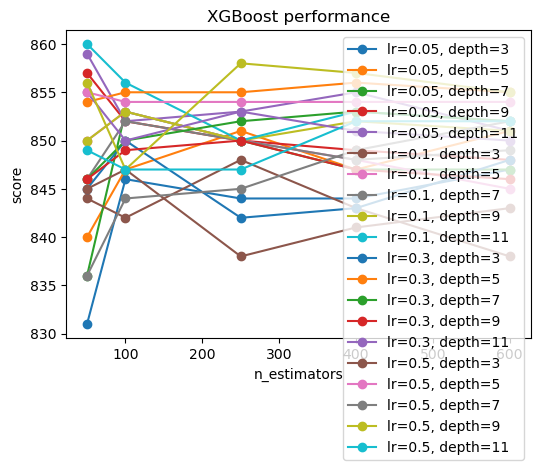

In [21]:
from xgboost import XGBClassifier

xgb_param_grid = [
    {"n_estimators": n, "max_depth": d, "learning_rate": lr}
    for n in [50, 100, 250, 400, 600]
    for d in [3, 5, 7, 9, 11]
    for lr in [0.05, 0.1, 0.3, 0.5]
]

xgb_model = XGBClassifier(
    eval_metric="logloss", random_state=0
)
xgb_results = []

for params in xgb_param_grid:
    xgb_model.set_params(**params)
    xgb_model.fit(X_train, y_train)

    _, score = online_policy(
        test_df=validation_set,
        estimator=xgb_model.predict,
        estimator_features=["LT", "LOS", "SST", "SST_month"] + process_features,
    )
    xgb_results.append({**params, "score": score})
    print(f"XGBoost {params} -> score {score:.3f}")

df_xgb = pd.DataFrame(xgb_results)

# plot: fix learning_rate, vary n_estimators and max_depth
plt.figure(figsize=(6, 4))
for lr in df_xgb["learning_rate"].unique():
    subset = df_xgb[df_xgb["learning_rate"] == lr]
    for d in subset["max_depth"].unique():
        sub2 = subset[subset["max_depth"] == d]
        plt.plot(
            sub2["n_estimators"], sub2["score"], marker="o", label=f"lr={lr}, depth={d}"
        )
plt.xlabel("n_estimators")
plt.ylabel("score")
plt.title("XGBoost performance")
plt.legend()
plt.show()


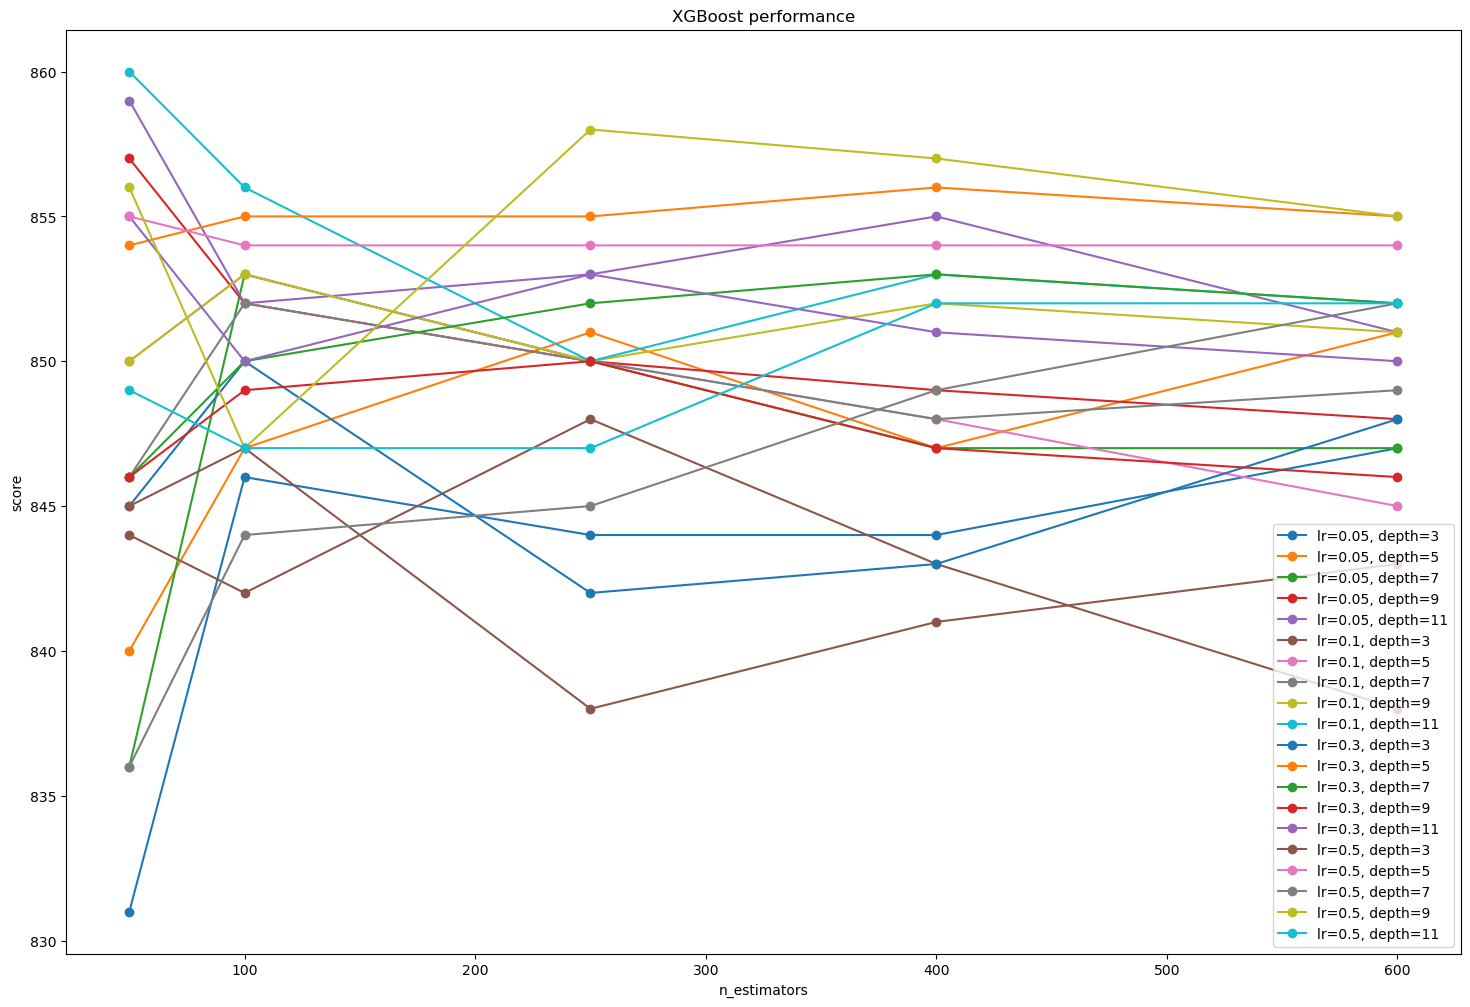

In [22]:
# plot: fix learning_rate, vary n_estimators and max_depth
plt.figure(figsize=(18, 12))
for lr in df_xgb["learning_rate"].unique():
    subset = df_xgb[df_xgb["learning_rate"] == lr]
    for d in subset["max_depth"].unique():
        sub2 = subset[subset["max_depth"] == d]
        plt.plot(
            sub2["n_estimators"], sub2["score"], marker="o", label=f"lr={lr}, depth={d}"
        )
plt.xlabel("n_estimators")
plt.ylabel("score")
plt.title("XGBoost performance")
plt.legend()
plt.show()


KNN {'n_neighbors': 2} -> score 674.000
KNN {'n_neighbors': 4} -> score 730.000
KNN {'n_neighbors': 6} -> score 755.000
KNN {'n_neighbors': 8} -> score 786.000
KNN {'n_neighbors': 10} -> score 793.000
KNN {'n_neighbors': 12} -> score 795.000
KNN {'n_neighbors': 14} -> score 805.000
KNN {'n_neighbors': 16} -> score 816.000
KNN {'n_neighbors': 18} -> score 815.000
KNN {'n_neighbors': 20} -> score 817.000
KNN {'n_neighbors': 22} -> score 820.000
KNN {'n_neighbors': 24} -> score 812.000
KNN {'n_neighbors': 26} -> score 813.000
KNN {'n_neighbors': 28} -> score 817.000
KNN {'n_neighbors': 30} -> score 814.000
KNN {'n_neighbors': 32} -> score 814.000
KNN {'n_neighbors': 34} -> score 814.000
KNN {'n_neighbors': 36} -> score 819.000
KNN {'n_neighbors': 38} -> score 816.000
KNN {'n_neighbors': 40} -> score 816.000
KNN {'n_neighbors': 42} -> score 816.000
KNN {'n_neighbors': 44} -> score 819.000
KNN {'n_neighbors': 46} -> score 821.000
KNN {'n_neighbors': 48} -> score 822.000
KNN {'n_neighbors': 

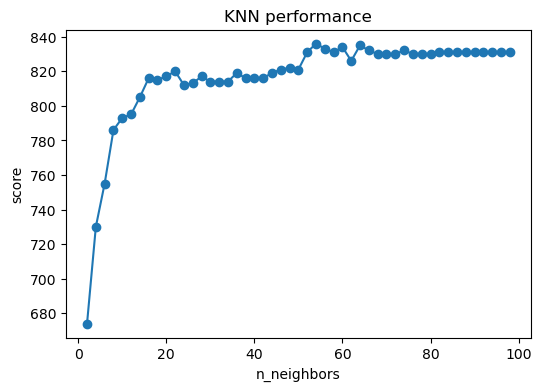

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knn_param_grid = [{"n_neighbors": k} for k in range(2,100,2)]

knn_model = KNeighborsClassifier(metric="cosine")
knn_results = []

for params in knn_param_grid:
    knn_model.set_params(**params)
    knn_model.fit(X_train, y_train)

    _, score = online_policy(
        test_df=validation_set,
        estimator=knn_model.predict,
        estimator_features=["LT", "LOS", "SST", "SST_month"] + process_features,
    )
    knn_results.append({**params, "score": score})
    print(f"KNN {params} -> score {score:.3f}")

df_knn = pd.DataFrame(knn_results)

# plot
plt.figure(figsize=(6, 4))
plt.plot(df_knn["n_neighbors"], df_knn["score"], marker="o")
plt.xlabel("n_neighbors")
plt.ylabel("score")
plt.title("KNN performance")
plt.show()


RandomForest {'n_estimators': 50, 'max_depth': 3} -> score 831.000
RandomForest {'n_estimators': 50, 'max_depth': 6} -> score 832.000
RandomForest {'n_estimators': 50, 'max_depth': 9} -> score 833.000
RandomForest {'n_estimators': 50, 'max_depth': 12} -> score 845.000
RandomForest {'n_estimators': 50, 'max_depth': 15} -> score 849.000
RandomForest {'n_estimators': 50, 'max_depth': 18} -> score 837.000
RandomForest {'n_estimators': 50, 'max_depth': 21} -> score 836.000
RandomForest {'n_estimators': 100, 'max_depth': 3} -> score 831.000
RandomForest {'n_estimators': 100, 'max_depth': 6} -> score 831.000
RandomForest {'n_estimators': 100, 'max_depth': 9} -> score 837.000
RandomForest {'n_estimators': 100, 'max_depth': 12} -> score 838.000
RandomForest {'n_estimators': 100, 'max_depth': 15} -> score 846.000
RandomForest {'n_estimators': 100, 'max_depth': 18} -> score 841.000
RandomForest {'n_estimators': 100, 'max_depth': 21} -> score 842.000
RandomForest {'n_estimators': 250, 'max_depth':

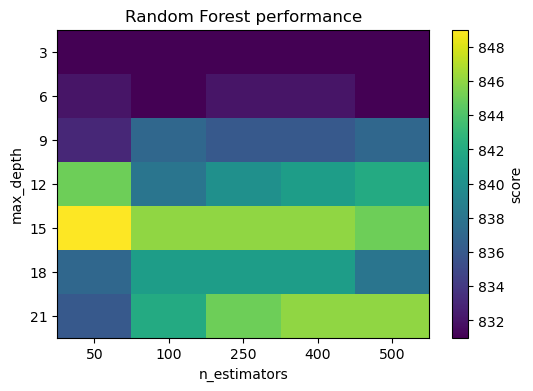

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_param_grid = [
    {"n_estimators": n, "max_depth": d}
    for n in [50, 100, 250, 400, 500]
    for d in range(3, X_train.shape[1], 3)
]

rf_model = RandomForestClassifier(random_state=0, n_jobs=-1)
rf_results = []

for params in rf_param_grid:
    rf_model.set_params(**params)
    rf_model.fit(X_train, y_train)

    _, score = online_policy(
        test_df=validation_set,
        estimator=rf_model.predict,
        estimator_features=["LT", "LOS", "SST", "SST_month"] + process_features,
    )
    rf_results.append({**params, "score": score})
    print(f"RandomForest {params} -> score {score:.3f}")

df_rf = pd.DataFrame(rf_results)

# plot
pivot_rf = df_rf.pivot(index="max_depth", columns="n_estimators", values="score")

plt.figure(figsize=(6, 4))
plt.imshow(pivot_rf, cmap="viridis", aspect="auto")
plt.colorbar(label="score")
plt.xticks(range(len(pivot_rf.columns)), pivot_rf.columns)
plt.yticks(range(len(pivot_rf.index)), pivot_rf.index)
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.title("Random Forest performance")
plt.show()


GradientBoosting {'n_estimators': 50, 'learning_rate': 0.05} -> score 837.000
GradientBoosting {'n_estimators': 50, 'learning_rate': 0.1} -> score 849.000
GradientBoosting {'n_estimators': 50, 'learning_rate': 0.25} -> score 839.000
GradientBoosting {'n_estimators': 50, 'learning_rate': 0.5} -> score 846.000
GradientBoosting {'n_estimators': 100, 'learning_rate': 0.05} -> score 847.000
GradientBoosting {'n_estimators': 100, 'learning_rate': 0.1} -> score 848.000
GradientBoosting {'n_estimators': 100, 'learning_rate': 0.25} -> score 845.000
GradientBoosting {'n_estimators': 100, 'learning_rate': 0.5} -> score 836.000
GradientBoosting {'n_estimators': 200, 'learning_rate': 0.05} -> score 849.000
GradientBoosting {'n_estimators': 200, 'learning_rate': 0.1} -> score 853.000
GradientBoosting {'n_estimators': 200, 'learning_rate': 0.25} -> score 837.000
GradientBoosting {'n_estimators': 200, 'learning_rate': 0.5} -> score 837.000
GradientBoosting {'n_estimators': 300, 'learning_rate': 0.05} 

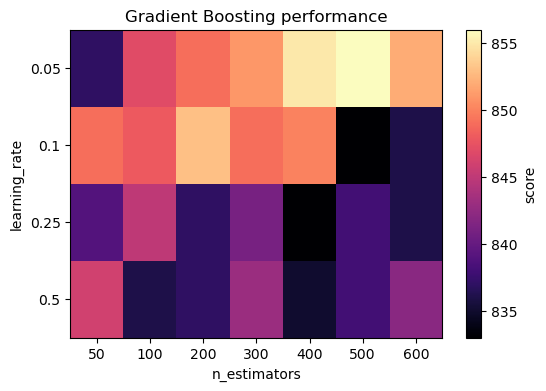

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

gb_param_grid = [
    {"n_estimators": n, "learning_rate": lr} for n in [50, 100, 200, 300, 400, 500, 600] for lr in [0.05, 0.1, 0.25, 0.5]
]

gb_model = GradientBoostingClassifier(random_state=0)
gb_results = []

for params in gb_param_grid:
    gb_model.set_params(**params)
    gb_model.fit(X_train, y_train)

    _, score = online_policy(
        test_df=validation_set,
        estimator=gb_model.predict,
        estimator_features=["LT", "LOS", "SST", "SST_month"] + process_features,
    )
    gb_results.append({**params, "score": score})
    print(f"GradientBoosting {params} -> score {score:.3f}")

df_gb = pd.DataFrame(gb_results)

# plot
pivot_gb = df_gb.pivot(index="learning_rate", columns="n_estimators", values="score")
plt.figure(figsize=(6, 4))
plt.imshow(pivot_gb, cmap="magma", aspect="auto")
plt.colorbar(label="score")
plt.xticks(range(len(pivot_gb.columns)), pivot_gb.columns)
plt.yticks(range(len(pivot_gb.index)), pivot_gb.index)
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.title("Gradient Boosting performance")
plt.show()


In [27]:
best_scores = {}
best_hyperparams = {}

int_params = {"max_depth", "n_estimators", "min_samples_split", "n_neighbors"}
float_params = {"learning_rate"}

models_info = {
    "Decision Tree": (dt_model, df_dt, ["max_depth", "min_samples_split"]),
    "Random Forest": (rf_model, df_rf, ["n_estimators", "max_depth"]),
    "Gradient Boosting": (gb_model, df_gb, ["n_estimators", "learning_rate"]),
    "XGBoost": (xgb_model, df_xgb, ["n_estimators", "max_depth", "learning_rate"]),
    "KNN": (knn_model, df_knn, ["n_neighbors"]),
}

for name, (model, df, params) in models_info.items():
    best = df.loc[df["score"].idxmax()]
    best_params = {}

    for p in params:
        val = best[p]
        # convert numpy types to Python
        if hasattr(val, "item"):
            val = val.item()
        # enforce int or float
        if p in int_params:
            val = int(val)
        elif p in float_params:
            val = float(val)
        best_params[p] = val

    model.set_params(**best_params)
    model.fit(X_train, y_train)

    _, score = online_policy(
        test_df=validation_set,
        estimator=model.predict,
        estimator_features=["LT", "LOS", "SST", "SST_month"] + process_features,
    )
    best_scores[name] = score
    best_hyperparams[name] = best_params
    print(f"Best {name}: {best_params} -> score on validation set: {score:.3f}")



Best Decision Tree: {'max_depth': 1, 'min_samples_split': 2} -> score on validation set: 831.000
Best Random Forest: {'n_estimators': 50, 'max_depth': 15} -> score on validation set: 849.000
Best Gradient Boosting: {'n_estimators': 500, 'learning_rate': 0.05} -> score on validation set: 856.000
Best XGBoost: {'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1} -> score on validation set: 860.000
Best KNN: {'n_neighbors': 54} -> score on validation set: 836.000


Greedy policy on test_set -> score 873.0/940.0
Decision Tree on test_set -> score 873.000/940.0
Random Forest on test_set -> score 873.000/940.0
Gradient Boosting on test_set -> score 875.000/940.0


/opt/miniconda3/envs/mio_ambiente/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:35:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost on test_set -> score 860.000/940.0
KNN on test_set -> score 819.000/940.0


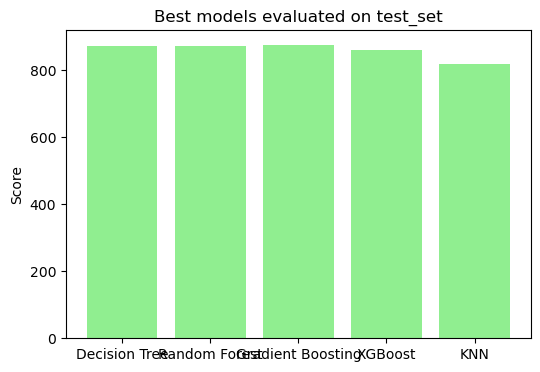

In [28]:
# dizionario con i modelli base
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "XGBoost": XGBClassifier(
        use_label_encoder=False, eval_metric="logloss", random_state=0
    ),
    "KNN": KNeighborsClassifier(),
}

# valutazione su test_set
scores_test = {}

_, greedy_score2 = online_policy(
    test_df=test_df,
    estimator=greedy_policy,
    estimator_features=["LT", "LOS", "SST", "SST_month"] + process_features,
)
print(f"Greedy policy on test_set -> score {greedy_score2}/{score_oracle_test}")

for name, model in models.items():
    params = best_hyperparams[name]
    model.set_params(**params)
    model.fit(X_train, y_train)  # riaddestriamo sempre sul training set originale

    _, score = online_policy(
        test_df=test_df,
        estimator=model.predict,
        estimator_features=["LT", "LOS", "SST", "SST_month"] + process_features,
    )
    scores_test[name] = score
    print(f"{name} on test_set -> score {score:.3f}/{score_oracle_test}")

# grafico comparativo su test_set
plt.figure(figsize=(6, 4))
plt.bar(scores_test.keys(), scores_test.values(), color="lightgreen")
plt.ylabel("Score")
plt.title("Best models evaluated on test_set")
plt.show()


In [22]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators = 250, max_depth=12)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=250, n_jobs=-1,
                       random_state=0)

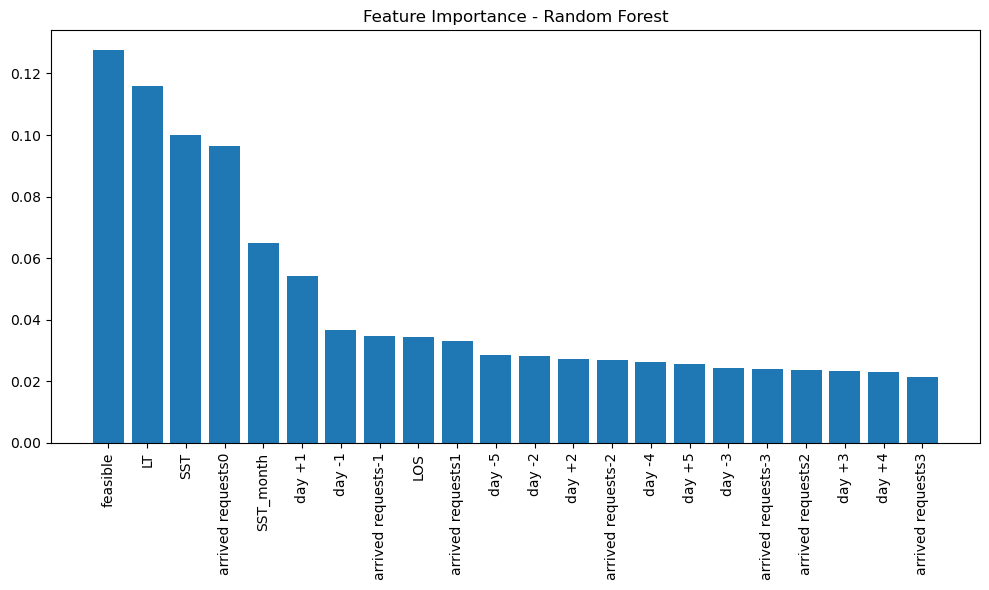

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()


/var/folders/qg/w61l7rsj71l06c11y6x57vnw0000gn/T/ipykernel_1021/1632176585.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.686868686868687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_temp.iloc[:, 2] = val  # sostituisco la colonna 2 con il valore della griglia


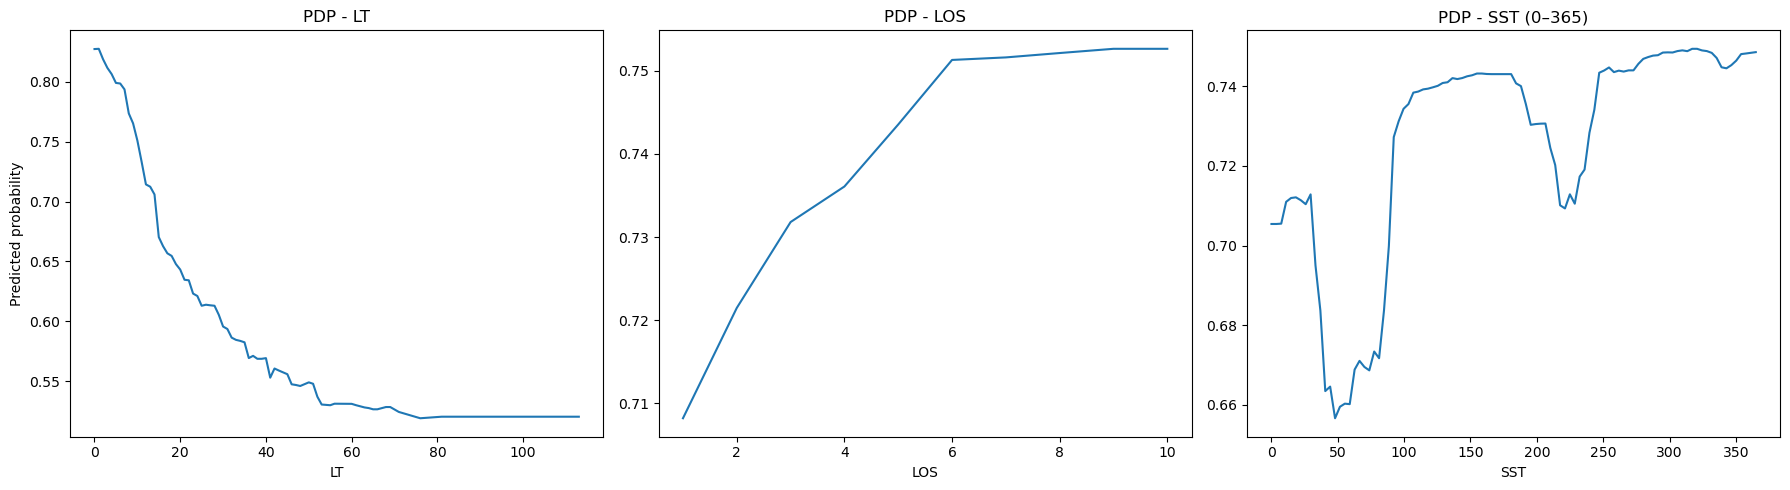

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import partial_dependence

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Feature 0 ---
pd0 = partial_dependence(rf_model, X_train, features=[0], grid_resolution=100)
x0 = pd0.grid_values[0]
y0 = pd0.average[0].ravel()
axes[0].plot(x0, y0)
axes[0].set_title(f"PDP - {X_train.columns[0]}")
axes[0].set_xlabel(X_train.columns[0])
axes[0].set_ylabel("Predicted probability")

# --- Feature 1 ---
pd1 = partial_dependence(rf_model, X_train, features=[1], grid_resolution=100)
x1 = pd1.grid_values[0]
y1 = pd1.average[0].ravel()
axes[1].plot(x1, y1)
axes[1].set_title(f"PDP - {X_train.columns[1]}")
axes[1].set_xlabel(X_train.columns[1])

# --- Feature 2 (range limitato 0–365) ---
grid_2 = np.linspace(0, 365, 100)  # griglia personalizzata
averages = []

# Copia dei dati
X_temp = X_train.copy()

for val in grid_2:
    X_temp.iloc[:, 2] = val  # sostituisco la colonna 2 con il valore della griglia
    pred = rf_model.predict_proba(X_temp)[:, 1].mean()  # probabilità media classe 1
    averages.append(pred)

axes[2].plot(grid_2, averages)
axes[2].set_title(f"PDP - {X_train.columns[2]} (0–365)")
axes[2].set_xlabel(X_train.columns[2])

plt.tight_layout()
plt.show()


/var/folders/qg/w61l7rsj71l06c11y6x57vnw0000gn/T/ipykernel_1021/38706864.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '3.686868686868687' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_temp.iloc[:, 2] = val  # sostituisco la colonna 2 con il valore della griglia


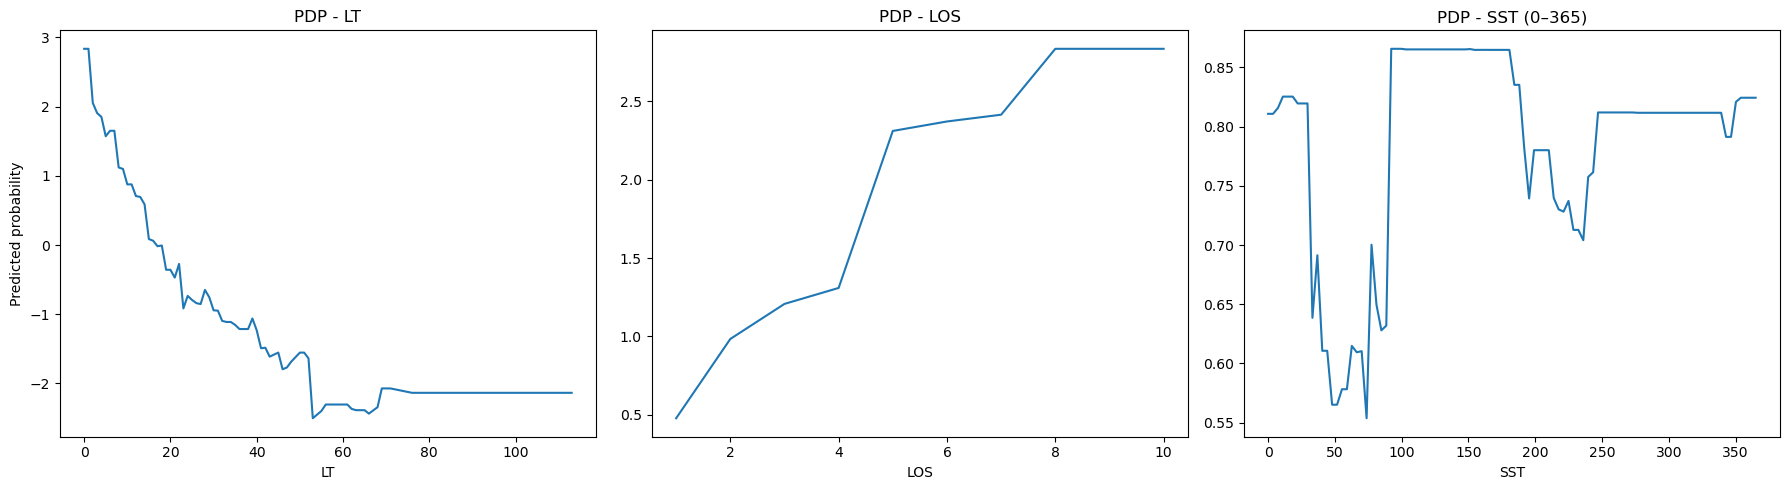

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import partial_dependence

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Feature 0 ---
pd0 = partial_dependence(gb_model, X_train, features=[0], grid_resolution=100)
x0 = pd0.grid_values[0]
y0 = pd0.average[0].ravel()
axes[0].plot(x0, y0)
axes[0].set_title(f"PDP - {X_train.columns[0]}")
axes[0].set_xlabel(X_train.columns[0])
axes[0].set_ylabel("Predicted probability")

# --- Feature 1 ---
pd1 = partial_dependence(gb_model, X_train, features=[1], grid_resolution=100)
x1 = pd1.grid_values[0]
y1 = pd1.average[0].ravel()
axes[1].plot(x1, y1)
axes[1].set_title(f"PDP - {X_train.columns[1]}")
axes[1].set_xlabel(X_train.columns[1])

# --- Feature 2 (range limitato 0–365) ---
grid_2 = np.linspace(0, 365, 100)  # griglia personalizzata
averages = []

# Copia dei dati
X_temp = X_train.copy()

for val in grid_2:
    X_temp.iloc[:, 2] = val  # sostituisco la colonna 2 con il valore della griglia
    pred = gb_model.predict_proba(X_temp)[:, 1].mean()  # probabilità media classe 1
    averages.append(pred)

axes[2].plot(grid_2, averages)
axes[2].set_title(f"PDP - {X_train.columns[2]} (0–365)")
axes[2].set_xlabel(X_train.columns[2])

plt.tight_layout()
plt.show()
